In [1]:
import time

print 'Last update:', time.ctime(time.time())  


Last update: Tue Jan 14 18:01:48 2020


(adapted from: http://localhost:8888/notebooks/develop/SWOT/2019-09-20_Z_NATL60_context_classes_gradlap_timeMean_BLACK.ipynb)

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Necessary modules:

In [3]:
import matplotlib
import matplotlib.style
from matplotlib import pyplot as plt 
import matplotlib.gridspec as gridspec

import xarray as xr
from mpl_toolkits.basemap import Basemap

import numpy as np
import GriddedData

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, Basemap, ipykernel, jupyter, notebook

Software,Version
Python,2.7.11 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython,5.8.0
OS,Darwin 16.7.0 x86_64 i386 64bit
numpy,1.16.4
matplotlib,2.2.2
xarray,0.10.6
Basemap,1.0.8
ipykernel,4.10.1
jupyter,1.0.0
notebook,5.7.8


# Parameters:

### Physical parameters:

In [5]:
grav = 9.81

### Figure parameters:

In [6]:
matplotlib.style.use('classic')
matplotlib.rcParams.update({'font.size': 12})

# Defining necessary functions:

In [7]:
def gradi(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.ma.zeros([m,n])

    M[0:-1,:] = np.ma.subtract(I[1::,:], I[0:-1,:])
    return M

def gradj(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.ma.zeros([m,n])
    M[:,0:-1] =  np.ma.subtract(I[:,1::], I[:,0:-1])
    return M


In [8]:
def div(px, py): 
    """
    Calculates the divergence of a vector (px, py) and gives M as ouput
    ; where px and py have the some size and are the gradient in x and y respectively 
    of a variable p.
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    """
    m, n = px.shape
    M = np.ma.zeros([m,n])
    Mx = np.ma.zeros([m,n])
    My = np.ma.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M

def laplacian(u):
    """
    Calculates the laplacian of u using the divergence and gradient functions and gives 
    as output Ml.
    """
    Ml = div(gradi(u), gradj(u));
    return Ml

In [9]:
def masked(array):
    m1 = np.ma.masked_invalid(array)
    m2= np.ma.masked_equal(m1,0.)
    return m2

def rel_vort_griddedData(lat, lon, data):
    mgrd = GriddedData.grid2D(navlat=lat, navlon=lon)
    corio = GriddedData.corio(mgrd)
    lap = mgrd.div(mgrd.grad(data))
    lap = np.ma.masked_greater(masked(lap),10.)
    rel_vort = grav * lap / corio 
    return rel_vort

# The pseudo-SWOT data is generated from the NATL60 simulation:
### Data obtained from: http://servdap.legi.grenoble-inp.fr/meom/NATL60MED/NATL60MED-CJM165-S/
### File: NATL60MED-CJM165_y2012m06d14-y2013m10d01.1d_gridTsurf.nc

In [10]:
datadir_nemo = '/Users/laura/Documents/data/natl60/'
filename_nemo = 'NATL60MED-CJM165_y2012m06d14-y2013m10d01.1d_gridTsurf.nc'

In [11]:
def read_data_nemo_all(tt):    
    filenc = datadir_nemo + filename_nemo
    xds = xr.open_dataset(filenc, engine='netcdf4', lock=False)
    ssh = xds.sossheig[tt,:,:]
    lat = xds.nav_lat
    lon = xds.nav_lon
    tim = xds.time_counter
    sshm_hi = ssh.to_masked_array()
    lat_hi = lat.to_masked_array()
    lon_hi = lon.to_masked_array()
    return sshm_hi, lat_hi, lon_hi, tim

In [12]:
ssh_hi, lat_hi, lon_hi, tim_hi = read_data_nemo_all(0)

# Subselecting the box region: 

In [13]:
blomin = -1.5
blomax = 5
blamin = 35.5
blamax = 40.5

In [14]:
indla = np.where((lat_hi[:,0] >= blamin) & (lat_hi[:,0] <= blamax))   
indlo = np.where((lon_hi[0,:] >= blomin) & (lon_hi[0,:] <= blomax))   

latb2 = lat_hi[indla[0],:]
latb = latb2[:,indlo[0]]
lonb2 = lon_hi[indla[0],:]
lonb = lonb2[:,indlo[0]]


# Subdomain:

In [15]:
def calc_norm_SB(var, order):
    if order == 1:
        
        gx = gradi(var)
        gx = np.ma.array(gx, mask = var.mask, fill_value = 1e20 )
        gy = gradj(var)
        gy = np.ma.array(gy, mask = var.mask, fill_value = 1e20 )

        grad_norm = np.nansum(gx[130:281,185:351]*gx[130:281,185:351] + gy[130:281,185:351]*gy[130:281,185:351])
        
        return grad_norm
    
    elif order == 2:
        
        lap = laplacian(var)
        lap = np.ma.array(lap, mask = var.mask, fill_value = 1e20 )

        lap_norm = np.nansum(lap[130:281,185:351] * lap[130:281,185:351])
        
        return lap_norm
    
    elif order == 3:
        lap = laplacian(var)
        lap = np.ma.array(lap, mask = var.mask, fill_value = 1e20 )

        gx_lap = gradi(lap)
        gx_lap = np.ma.array(gx_lap, mask = lap.mask, fill_value = 1e20 )
        gy_lap = gradj(lap)
        gy_lap = np.ma.array(gy_lap, mask = lap.mask, fill_value = 1e20 )

        grad_lap_norm = np.nansum(gx_lap[130:281,185:351]*gx_lap[130:281,185:351] + gy_lap[130:281,185:351]*gy_lap[130:281,185:351])
        
        return grad_lap_norm
    
    else:
        print 'Specify order!'

In [16]:
grad_norm_all_SB     = np.zeros(475)
lap_norm_all_SB      = np.zeros(475)
grad_lap_norm_all_SB = np.zeros(475)


In [17]:
for ii in xrange(0, 475): 
    ssh_hi, _, _, _ = read_data_nemo_all(ii)
    SSHb2 = ssh_hi[indla[0],:]
    SSHb = SSHb2[:,indlo[0]]

    grad_norm_all_SB[ii]     = calc_norm_SB(SSHb, 1)
    lap_norm_all_SB[ii]      = calc_norm_SB(SSHb, 2)
    grad_lap_norm_all_SB[ii] = calc_norm_SB(SSHb, 3)

# Calculate norm per season:

In [18]:
def read_data_nemo_seasons(date_ini, date_end):    
    filenc = datadir_nemo + filename_nemo
    xds = xr.open_dataset(filenc, engine='netcdf4', lock=False)
    ssha = xds.sossheig
    lat = xds.nav_lat
    lon = xds.nav_lon
    tima = xds.time_counter
    ssh = ssha.sel(dict(time_counter=slice(date_ini, date_end))) #'2013-02-01'
    tim = tima.sel(dict(time_counter=slice(date_ini, date_end)))
    sshm_hi = ssh.to_masked_array()
    lat_hi = lat.to_masked_array()
    lon_hi = lon.to_masked_array()
    return sshm_hi, lat_hi, lon_hi, tim

In [19]:
ssh_hi_FMA13, _, _, tim_hi_FMA13 = read_data_nemo_seasons('2013-02-01', '2013-04-30')

In [20]:
ssh_hi_JAS12, _, _, tim_hi_JAS12 = read_data_nemo_seasons('2012-07-01', '2012-09-30')

In [21]:
ssh_hi_JAS13, _, _, tim_hi_JAS13 = read_data_nemo_seasons('2013-07-01', '2013-09-30')

In [22]:
def norm_calc_set(tim, ssh, indla, indlo, domain):
    grad_norm_set     = np.zeros(len(tim))
    lap_norm_set      = np.zeros(len(tim))
    grad_lap_norm_set = np.zeros(len(tim))

    for ii in xrange(0, len(tim)): 
    
        ssh_hi_p = ssh[ii]
        SSHb2 = ssh_hi_p[indla[0],:]
        SSHb = SSHb2[:,indlo[0]]
        
        if domain == 'whole':
            grad_norm_set[ii]     = calc_norm(SSHb, 1)
            lap_norm_set[ii]      = calc_norm(SSHb, 2)
            grad_lap_norm_set[ii] = calc_norm(SSHb, 3)
            
        elif domain == 'sub':
            grad_norm_set[ii]     = calc_norm_SB(SSHb, 1)
            lap_norm_set[ii]      = calc_norm_SB(SSHb, 2)
            grad_lap_norm_set[ii] = calc_norm_SB(SSHb, 3)
            
        else:
            print('Problem')
            
    return grad_norm_set, lap_norm_set, grad_lap_norm_set

In [23]:
grad_norm_FMA13_SB, lap_norm_FMA13_SB, grad_lap_norm_FMA13_SB = norm_calc_set(tim_hi_FMA13, ssh_hi_FMA13, indla, indlo, 'sub')
grad_norm_JAS12_SB, lap_norm_JAS12_SB, grad_lap_norm_JAS12_SB = norm_calc_set(tim_hi_JAS12, ssh_hi_JAS12, indla, indlo, 'sub')
grad_norm_JAS13_SB, lap_norm_JAS13_SB, grad_lap_norm_JAS13_SB = norm_calc_set(tim_hi_JAS13, ssh_hi_JAS13, indla, indlo, 'sub')


/Users/laura/anaconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


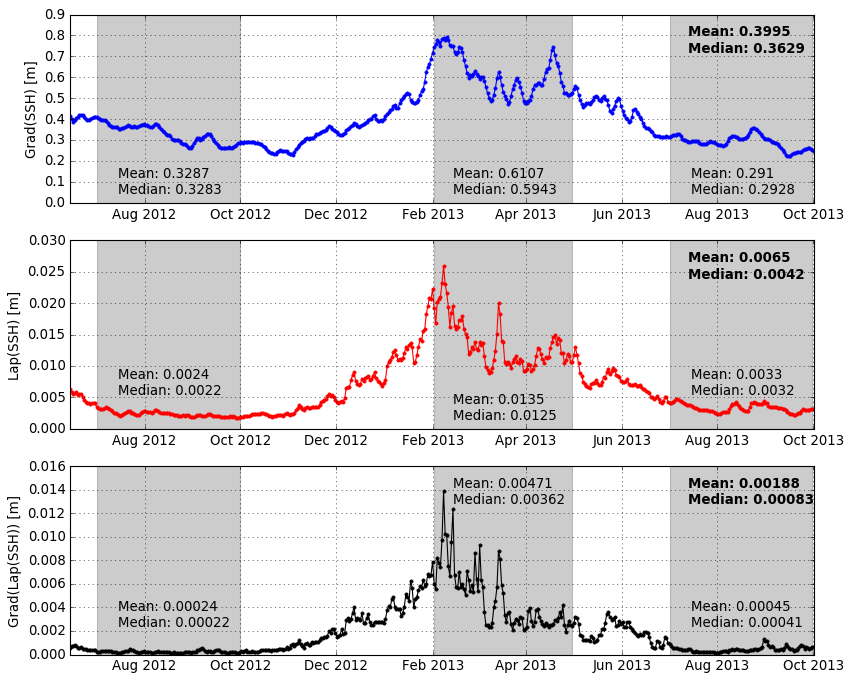

In [24]:
fig = plt.figure(figsize=(12,10))
fig.patch.set_facecolor('None')

ax1 = plt.subplot(3,1,1)
plt.plot(tim_hi, grad_norm_all_SB, '.-b')
plt.text(0.83, 0.8, 'Mean: ' + str(np.around(np.mean(grad_norm_all_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(grad_norm_all_SB), 4)), weight = 'bold', transform=ax1.transAxes)
#tim_hi[-80].data, 0.7
plt.ylim([0, 0.9])
plt.ylabel('Grad(SSH) [m]')
plt.grid()

plt.axvspan(tim_hi_FMA13[0].data, tim_hi_FMA13[-1].data, alpha=0.2, color='black')
ax1.text(0.515, 0.05, 'Mean: ' + str(np.around(np.mean(grad_norm_FMA13_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(grad_norm_FMA13_SB), 4)), transform=ax1.transAxes)
#tim_hi_FMA13[np.int(np.floor(len(tim_hi_FMA13)/2))]
#tim_hi_FMA13[1].data, 0.05

plt.axvspan(tim_hi_JAS12[0].data, tim_hi_JAS12[-1].data, alpha=0.2, color='black')
ax1.text(.065, 0.05, 'Mean: ' + str(np.around(np.mean(grad_norm_JAS12_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(grad_norm_JAS12_SB), 4)), transform=ax1.transAxes)

plt.axvspan(tim_hi_JAS13[0].data, tim_hi_JAS13[-1].data, alpha=0.2, color='black')
ax1.text(.835, 0.05, 'Mean: ' + str(np.around(np.mean(grad_norm_JAS13_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(grad_norm_JAS13_SB), 4)), transform=ax1.transAxes)

ax2 = plt.subplot(3,1,2)
plt.plot(tim_hi, lap_norm_all_SB, '.-r')
ax2.text(0.83, 0.8, 'Mean: ' + str(np.around(np.mean(lap_norm_all_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(lap_norm_all_SB), 4)), weight = 'bold', transform=ax2.transAxes)
#tim_hi[-80].data, 0.022
plt.ylim([0, 0.03])
plt.ylabel('Lap(SSH) [m]')
plt.grid()
plt.axvspan(tim_hi_FMA13[0].data, tim_hi_FMA13[-1].data, alpha=0.2, color='black')
ax2.text(0.515, 0.05, 'Mean: ' + str(np.around(np.mean(lap_norm_FMA13_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(lap_norm_FMA13_SB), 4)), transform=ax2.transAxes)
#tim_hi_FMA13[np.int(np.floor(len(tim_hi_FMA13)/2))]
# tim_hi_FMA13[1].data, 0.05

plt.axvspan(tim_hi_JAS12[0].data, tim_hi_JAS12[-1].data, alpha=0.2, color='black')
ax2.text(.065, 0.18, 'Mean: ' + str(np.around(np.mean(lap_norm_JAS12_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(lap_norm_JAS12_SB), 4)), transform=ax2.transAxes)

plt.axvspan(tim_hi_JAS13[0].data, tim_hi_JAS13[-1].data, alpha=0.2, color='black')
ax2.text(.835, 0.18, 'Mean: ' + str(np.around(np.mean(lap_norm_JAS13_SB), 4)) 
         + '\nMedian: ' + str(np.around(np.median(lap_norm_JAS13_SB), 4)), transform=ax2.transAxes)


ax3 = plt.subplot(3,1,3)
plt.plot(tim_hi, grad_lap_norm_all_SB, '.-k')
plt.text(0.83, 0.8, 'Mean: ' + str(np.around(np.mean(grad_lap_norm_all_SB), 5)) 
         + '\nMedian: ' + str(np.around(np.median(grad_lap_norm_all_SB), 5)), weight = 'bold', transform=ax3.transAxes)
#tim_hi[-80].data, 0.010
plt.ylim([0, 0.016])
plt.ylabel('Grad(Lap(SSH)) [m]')
plt.grid()
plt.axvspan(tim_hi_FMA13[0].data, tim_hi_FMA13[-1].data, alpha=0.2, color='black')
ax3.text(0.515, 0.8, 'Mean: ' + str(np.around(np.mean(grad_lap_norm_FMA13_SB), 5)) 
         + '\nMedian: ' + str(np.around(np.median(grad_lap_norm_FMA13_SB), 5)), transform=ax3.transAxes)
#tim_hi_FMA13[np.int(np.floor(len(tim_hi_FMA13)/2))]
# tim_hi_FMA13[1].data, 0.05

plt.axvspan(tim_hi_JAS12[0].data, tim_hi_JAS12[-1].data, alpha=0.2, color='black')
ax3.text(.065, 0.15, 'Mean: ' + str(np.around(np.mean(grad_lap_norm_JAS12_SB), 5)) 
         + '\nMedian: ' + str(np.around(np.median(grad_lap_norm_JAS12_SB), 5)), transform=ax3.transAxes)

plt.axvspan(tim_hi_JAS13[0].data, tim_hi_JAS13[-1].data, alpha=0.2, color='black')
ax3.text(.835, 0.15, 'Mean: ' + str(np.around(np.mean(grad_lap_norm_JAS13_SB), 5)) 
         + '\nMedian: ' + str(np.around(np.median(grad_lap_norm_JAS13_SB), 5)), transform=ax3.transAxes)

plt.savefig('figures/norms_intime_subdomain_seasons.png', bbox_inches='tight', dpi=100)

plt.show()